In [1]:
import numpy as np
import tensorflow as tf
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from PIL import Image
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, Concatenate
)
from tensorflow.keras.regularizers import l2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer, plot_histogram

In [2]:
def qft(circuit, n):
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            angle = np.pi / (2**(j - i))
            circuit.cp(angle, j, i)
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

In [3]:
def load_image_as_grayscale(image_path):
    image = Image.open(image_path).convert('L')
    image = image.resize((64, 64))
    return np.array(image) / 255.0  # Normalize

In [4]:
def visualize_statevector(image_data):
    flat_data = image_data.flatten()
    n = int(np.log2(len(flat_data)))
    if 2 ** n != len(flat_data):
        raise ValueError("Image data size must be a power of 2 for QFT.")
    norm_data = flat_data / np.linalg.norm(flat_data)
    state = Statevector(norm_data)
    print("Statevector Representation:")
    print(state)
    return state

In [5]:
def extract_qft_features(image_data, shots=1024):
    n = int(np.log2(image_data.size))
    if 2 ** n != image_data.size:
        raise ValueError("Image data size must be a power of 2 for QFT.")

    qc = QuantumCircuit(n, n)  # Create circuit with classical bits
    qft(qc, n)  # Apply QFT
    qc.measure(range(n), range(n))  # Ensure measurements are applied

    # Simulate circuit
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)

    # Run the simulation
    job = simulator.run(transpiled_qc, shots=shots)
    result = job.result()

    # Extract measurement probabilities
    counts = result.get_counts()  # This was causing the error

    if not counts:  # Handle empty results
        raise RuntimeError("Quantum circuit returned no counts. Check circuit structure.")

    probabilities = np.zeros(2**n)
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        probabilities[index] = count / shots

    return probabilities.reshape(64, 64, 1)


In [6]:
def collect_features(dataset_path):
    image_features, qft_features, labels = [], [], []
    for label in ['Real', 'Fake']:
        class_path = os.path.join(dataset_path, label)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image_data = load_image_as_grayscale(image_path)
            qft_data = extract_qft_features(image_data)
            image_features.append(image_data.reshape(64, 64, 1))
            qft_features.append(qft_data)
            labels.append(0 if label == 'Real' else 1)
    return np.array(image_features), np.array(qft_features), np.array(labels)

In [7]:
def create_cnn_model(image_shape, qft_shape):
    image_input = Input(shape=image_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001))(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    qft_input = Input(shape=qft_shape)
    z = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001))(qft_input)
    z = BatchNormalization()(z)
    z = MaxPooling2D(pool_size=(2, 2))(z)
    z = Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001))(z)
    z = BatchNormalization()(z)
    z = MaxPooling2D(pool_size=(2, 2))(z)
    z = Flatten()(z)
    combined = Concatenate()([x, z])
    combined = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.5)(combined)
    combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(1, activation='sigmoid')(combined)
    model = Model(inputs=[image_input, qft_input], outputs=output)
    return model

In [8]:
def plot_training_metrics(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

In [11]:
def plot_qft_circuit(n):
    qc = QuantumCircuit(n)
    qft(qc, n)
    qc.measure_all()
    return circuit_drawer(qc, output='mpl')

In [10]:
dataset_path = 'my_Train'
image_features, qft_features, labels = collect_features(dataset_path)
X_img_train, X_img_test, X_qft_train, X_qft_test, y_train, y_test = train_test_split(
    image_features, qft_features, labels, test_size=0.15, random_state=85
)

In [12]:
cnn_model = create_cnn_model(image_shape=(64, 64, 1), qft_shape=(64, 64, 1))
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [14]:
history = cnn_model.fit(
    [X_img_train, X_qft_train], y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.6361 - loss: 1.5976 - val_accuracy: 0.5055 - val_loss: 1.9003 - learning_rate: 0.0010
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.7558 - loss: 1.1869 - val_accuracy: 0.6387 - val_loss: 1.4425 - learning_rate: 0.0010
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.7960 - loss: 1.0067 - val_accuracy: 0.7947 - val_loss: 0.9196 - learning_rate: 0.0010
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.8299 - loss: 0.8596 - val_accuracy: 0.8150 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.8449 - loss: 0.8386 - val_accuracy: 0.7868 - val_loss: 0.9179 - learning_rate: 0.0010
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8825 - loss: 0.7690
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.8824

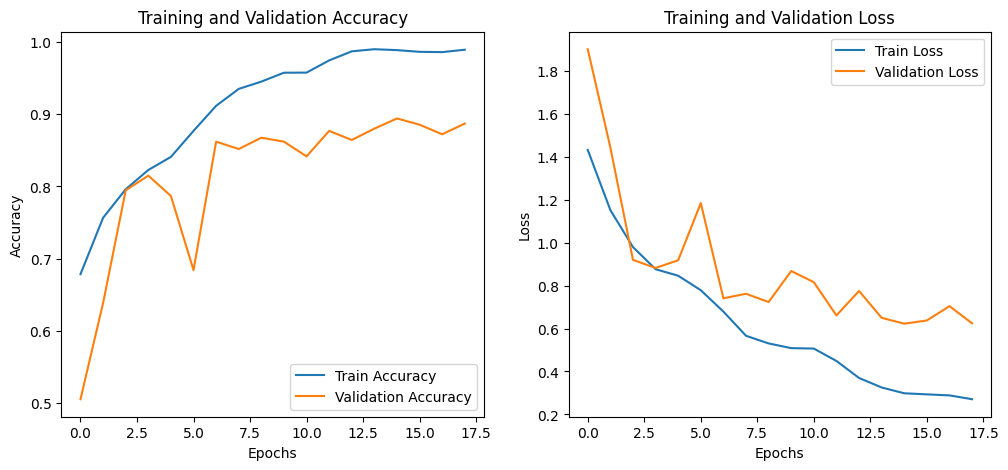

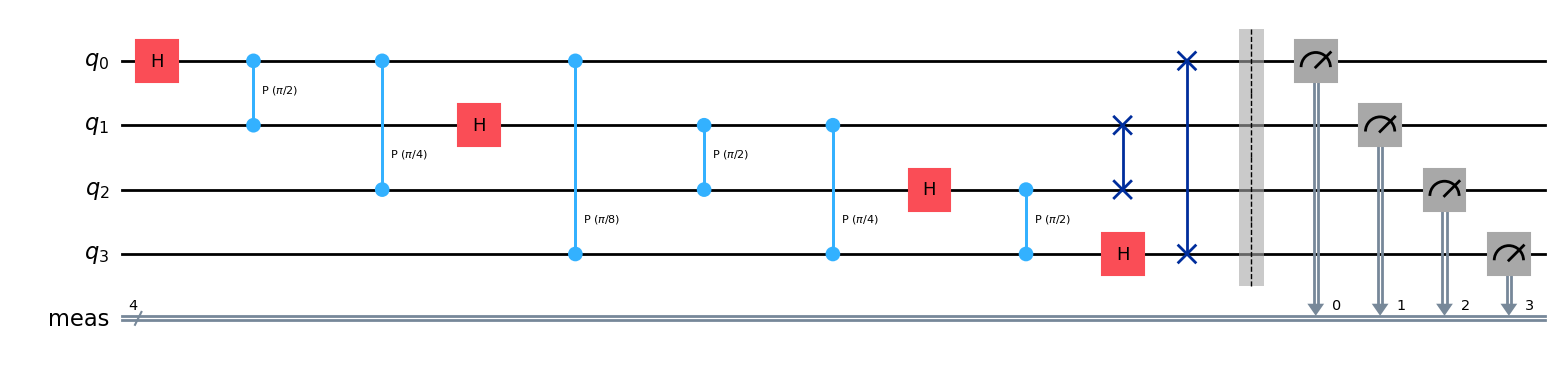

In [15]:
plot_training_metrics(history)
plot_qft_circuit(4)

In [16]:
image_sample = image_features[0]
visualize_statevector(image_sample)

Statevector Representation:
Statevector([0.02915263+0.j, 0.02816441+0.j, 0.02705265+0.j, ...,
             0.00926461+0.j, 0.01000578+0.j, 0.00926461+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Statevector([0.02915263+0.j, 0.02816441+0.j, 0.02705265+0.j, ...,
             0.00926461+0.j, 0.01000578+0.j, 0.00926461+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [17]:
test_loss, test_accuracy = cnn_model.evaluate([X_img_test, X_qft_test], y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8873 - loss: 0.6471
Test Accuracy: 0.8821, Test Loss: 0.6488
